# 2.b Test modèle avec prise en compte des données Covid
Les modèles de machine learning les plus performants avec nos données sont :
- xgboost
- CatBoost

Pour les comparer avec des modèles orientés séries temporelles (fbprophet), nous allons évaluer leur capacité de prédiction future. Pour chaque modèle, nous les entrainerons sur les données disponibles jusqu'à la date $t$ et ferons des prédictions sur les jours suivant.

Les paramètres à définir sont donc :
- `horizon` : l'horizon de prédiction
- `initial` : la période d'entrainement initial
- `period` : l'espacement temporelle entre deux entrainements.

In [4]:
horizon = 10
initial = 200 # en jours
period = 5

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [34]:
def preprocess(df: pd.DataFrame):
    """
    Enlève toutes les colonnes sauf la date, le débit horaire et le taux d'occupation
    et formatte les dates en type datetime
    pour ensuite en extraire année, jour, mois, heure et jour de la semaine
    Réordonne les données temporellement
    Resampling pour compléter les données absentes
    Interpolation temporelle des données
    """
    temp = df[["Débit horaire", "Taux d'occupation"]].copy()
    temp["Date et heure de comptage"] = pd.to_datetime(df["Date et heure de comptage"], utc=True)
    temp = temp.sort_values("Date et heure de comptage")
    temp = temp.set_index("Date et heure de comptage")
    temp = temp.resample("1H").first()
    temp["datetime"] = temp.index
    temp["year"] = temp.index.year
    temp["month"] = temp.index.month
    temp["day"] = temp.index.day
    temp["hour"] = temp.index.hour
    # Récupère les jours de la semaine : 0 -> lundi, 6 -> dimanche
    temp["dayofweek"] = temp.index.dayofweek
    temp[["Débit horaire", "Taux d'occupation"]] = temp[["Débit horaire", "Taux d'occupation"]].interpolate("time")
    return temp

def get_covid_data(path="data/OxCGRT_latest.csv"):
    """
    Récupère les données covid pour la France récoltées par Oxford
    Ces données apporte des informations sur les restrictions gouvernementales
    Une explication des données covid est disponible dans le fichier data/doc-oxford.pdf
    """
    oxford_data = pd.read_csv(path, sep=";")
    france_data = oxford_data[oxford_data["CountryName"] == "France"]
    france_data = france_data[['Date', 'C1_School closing',
        'C2_Workplace closing', 'C3_Cancel public events',
        'C4_Restrictions on gatherings', 'C5_Close public transport',
        'C6_Stay at home requirements',
        'C7_Restrictions on internal movement', 'StringencyLegacyIndexForDisplay',
        'ContainmentHealthIndexForDisplay',]]
    france_data["Date"] = pd.to_datetime(france_data["Date"].astype(str).apply(lambda date: f"{date[:4]}-{date[4:6]}-{date[6:]}"))
    france_data.index = france_data["Date"]
    france_data = france_data.interpolate("time")
    france_data = france_data.reset_index(drop=True)
    return france_data

def add_covid_data(df: pd.DataFrame, covid_data_france:pd.DataFrame):
    """
    df est la base de données à laquelle on veut ajouter les données covid
    df doit contenir une colonne datetime de type datetime
    !Attention! : pour éviter les problèmes lors de la jointure la colonne index de la 
    base de données est supprimée
    """
    # Préparation de la base de données pour le join
    temp = df.copy()
    temp["Date"] = pd.to_datetime(temp.datetime.dt.date)
    temp = temp.reset_index(drop=True)

    # Join
    # Comme les données manquantes sont uniquement celles avant 2020
    # la valeurs des indicateurs associées peut être 0
    joined = pd.merge(temp, covid_data_france, how="left", on="Date").fillna(0)
    return joined

In [45]:
def prepare_time_series(df: pd.DataFrame, time_column:str, target_column:str, regressor_list=[]):
    if len(regressor_list) > 0:
        temp = df[regressor_list].copy()
    else:
        temp = pd.DataFrame()
    temp["ds"] = pd.to_datetime(df[time_column], utc=True).dt.tz_convert("Europe/Paris")
    temp["ds"] = pd.to_datetime(temp["ds"].dt.strftime('%Y-%m-%d %H:%M:%S'))
    temp["y"] = np.log(df[target_column])
    temp = temp.sort_values("ds")
    temp = temp.reset_index(drop=True)
    temp.index = temp["ds"]
    return temp

In [51]:
france_data = get_covid_data("../data/OxCGRT_latest.csv")
raw_convention = pd.read_csv('../data/comptages-routiers-permanents-convention.csv', sep=";")
data_convention = preprocess(raw_convention)
data_convention_covid = add_covid_data(data_convention, france_data)
raw_champs = pd.read_csv('../data/comptages-routiers-permanents-champs.csv', sep=";")
data_champs = preprocess(raw_champs)
data_champs_covid = add_covid_data(data_champs, france_data)
raw_peres = pd.read_csv('../data/comptages-routiers-permanents-peres.csv', sep=";")
data_peres = preprocess(raw_peres)
data_peres_covid = add_covid_data(data_peres, france_data)
data_peres_covid.head()

,Débit horaire,Taux d'occupation,datetime,year,month,day,hour,dayofweek,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,StringencyLegacyIndexForDisplay,ContainmentHealthIndexForDisplay
0,259.0,3.00611,2019-11-01 03:00:00+00:00,2019,11,1,3,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,197.0,2.50778,2019-11-01 04:00:00+00:00,2019,11,1,4,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,163.0,2.05111,2019-11-01 05:00:00+00:00,2019,11,1,5,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,170.0,2.08944,2019-11-01 06:00:00+00:00,2019,11,1,6,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,225.0,2.91500,2019-11-01 07:00:00+00:00,2019,11,1,7,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='ds'>

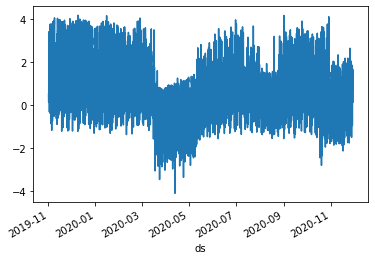

In [52]:
regressors = france_data.drop(columns=["Date"]).columns
ts_convention_occupation = prepare_time_series(data_convention_covid, "datetime", "Taux d'occupation", regressors)
ts_convention_occupation["y"].plot()

In [53]:
ts_convention_occupation.head()

,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,StringencyLegacyIndexForDisplay,ContainmentHealthIndexForDisplay,ds,y
ds,,,,,,,,,,,
2019-11-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-01 04:00:00,0.517138
2019-11-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-01 05:00:00,0.343987
2019-11-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-01 06:00:00,0.305033
2019-11-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-01 07:00:00,0.131519
2019-11-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-01 08:00:00,0.619081
